In [3]:
import os, json, getpass, asyncio, logging, requests, inspect
from typing import Literal

# from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.chat_models import init_chat_model

from langgraph.types import Command
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_community.tools import DuckDuckGoSearchRun

from langgraph.prebuilt import create_react_agent
# from langgraph_supervisor import create_supervisor
from langchain.tools import Tool

from fastmcp import Client

ModuleNotFoundError: No module named 'requests'

In [2]:
from langchain_core.tools import tool, ToolException
from functools import partial
from functools import wraps
from fastmcp.utilities.types import TextContent
from mcp.server.fastmcp import Context

In [3]:
# Env
from dotenv import load_dotenv
_ = load_dotenv()

def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")

In [4]:
# Google API Key and Model
os.getenv("GOOGLE_API_KEY")
gmodel = init_chat_model("google_genai:gemini-2.0-flash")
gchat = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

# messages = [
#     (
#         "system",
#         "You are a helpful assistant that translates English to French. Translate the user sentence.",
#     ),
#     ("human", "I love programming."),
# ]
# ai_msg = gchat.invoke(messages)
# ai_msg

In [5]:
async def _search_data_async(question: str, limit: int = 8) -> str:
    async with Client("http://127.0.0.1:8050/mcp-server/mcp") as c:
        res = await c.call_tool("search_data", {"query": question, "limit": limit})
        return json.loads(res)["answer"]

In [6]:
def sync_bridge(coro_fn): 
    """
    Décorateur : transforme une coroutine en fonction bloquante
    qui s'exécute indifféremment dans un thread Jupyter ou non.
    """
    @wraps(coro_fn)
    def _wrapper(*args, **kwargs):
        try:
            # ⓵ Cas Jupyter ou event-loop déjà active
            loop = asyncio.get_running_loop()
        except RuntimeError:
            loop = None

        if loop and loop.is_running():
            # On poste la coroutine dans la boucle existante
            fut = asyncio.run_coroutine_threadsafe(coro_fn(*args, **kwargs), loop)
            return fut.result()
        else:
            # ⓶ Thread sans boucle → on en crée une locale
            return asyncio.run(coro_fn(*args, **kwargs))
    _wrapper.__signature__ = inspect.signature(coro_fn)
    return _wrapper         # bloque cette cellule - OK pour un tool

In [7]:
async def _call_search(query: str, limit: int):
    async with Client("http://127.0.0.1:8050/mcp-server/mcp") as c:
        res = await c.call_tool("search_data", {"ctx": {}, "query": query, "limit": limit})

    # ── normaliser ─────────────────────────────
    if isinstance(res, TextContent):
        payload = res.text
    elif isinstance(res, (bytes, str)):
        payload = res
    elif isinstance(res, list) and res and isinstance(res[0], TextContent):
        payload = res[0].text
    else:
        raise ValueError(f"Format inattendu: {type(res)}")

    data = json.loads(payload)      # <─ plus de TypeError
    return data["answer"]

In [8]:
@tool(
    # name        = "RealEstateRAGTool",
    description = "Recherche projets et biens immobiliers.",
)
@sync_bridge # <- garde la compatibilité sync
async def realestate_rag(question: str, limit: int = 20) -> str: # _search_data
    """Interroge GraphRAG : retourne une réponse textuelle."""
    try:
        return await _call_search(question, limit)
    except ToolException as e:
        return f"[ERREUR RAG] {e}"

### 1. Create worker agents

In [9]:
# -----------------------------
# InfoAgent (RAG-based agent for project/property info)
# -----------------------------
info_agent = create_react_agent(
    model=gchat,
    tools=[realestate_rag],  # rag_tool : Replace with my custom RAG retriever tools
    prompt=(
        "You are the InfoAgent.\n"
        "- Answer questions about real estate projects, properties, availability, location, prices, and financial conditions.\n"
        "- Use only the available rag_tool to query property databases or retrieve knowledge from the RAG system.\n"
        "- You may also explain financial aspects such as payment options or loan eligibility (just based on information from the tool).\n"
        "- Do NOT collect client personal information.\n"
        "- Do NOT schedule appointments."
        "- Do Not give any external information from the llm model, only use the rag_tool to answer questions.\n"
        "- If you don't know the answer, say 'I don't know' or 'I cannot answer that'.\n"
    ),
    name="InfoAgent"
)

In [10]:
# 🟢 Appel unique
resp = info_agent.invoke(
    # {"messages":[{"role":"user","content":"Quel est le prix des F2 à Bouskoura ?"}]}
    {"messages":[{"role":"user","content":"Y a t-il des laucaux commerciaux à Bouskoura ? Peut-on trouver des locaux commerciaux à moins de 500 000 MAD ?"}]}
)
print(resp)               # dict complet
print(resp["messages"][-1].content)  # texte final

{'messages': [HumanMessage(content='Y a t-il des laucaux commerciaux à Bouskoura ? Peut-on trouver des locaux commerciaux à moins de 500 000 MAD ?', additional_kwargs={}, response_metadata={}, id='56293d74-36ed-4c3c-b256-93ec1406da43'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'realestate_rag', 'arguments': '{"limit": 5.0, "question": "locaux commerciaux \\u00e0 Bouskoura \\u00e0 moins de 500 000 MAD"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, name='InfoAgent', id='run--1551a336-9ff5-4840-9459-c897566c243e-0', tool_calls=[{'name': 'realestate_rag', 'args': {'limit': 5.0, 'question': 'locaux commerciaux à Bouskoura à moins de 500 000 MAD'}, 'id': '1b602601-90b2-4e19-9792-739d6b223d17', 'type': 'tool_call'}], usage_metadata={'input_tokens': 189, 'output_tokens': 26, 'total_tokens': 215, 'input_token_details': {'cache_read': 0}}), ToolMessa

In [14]:
# 🟢 Streaming
for chunk in info_agent.stream(
    # {"messages":[{"role":"user","content":"Quel est le prix des F3 à Bouskoura ?"}]}
    # {"messages":[{"role":"user","content":"Quels biens avez-vous à vendre à Casablanca ?"}]}
    {"messages":[{"role":"user","content":"Dannez moi la liste des projets situés à Casablanca ?"}]}
):
    print(chunk)

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'realestate_rag', 'arguments': '{"limit": 5.0, "question": "projets situ\\u00e9s \\u00e0 Casablanca"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, name='InfoAgent', id='run--a0a0d21d-119b-4b8b-a719-95911a9e9029-0', tool_calls=[{'name': 'realestate_rag', 'args': {'limit': 5.0, 'question': 'projets situés à Casablanca'}, 'id': '17dd5458-ef8b-4fdb-93de-adafef151c30', 'type': 'tool_call'}], usage_metadata={'input_tokens': 166, 'output_tokens': 12, 'total_tokens': 178, 'input_token_details': {'cache_read': 0}})]}}
{'tools': {'messages': [ToolMessage(content='À Casablanca, le Groupe Addoha propose les projets suivants\xa0:\n\n* **AL FATH (Route Arrahma):** Appartements F3 économiques à partir de 200\xa0000 dhs.  Le projet inclut une école, une crèche, une mosquée, un centre de santé

In [15]:
# -----------------------------
# Web Search (Use DuckDuckGo)
# -----------------------------

webSearch_tool = DuckDuckGoSearchRun()
# web_search_results = search_tool.invoke("What's a 'node' in LangGraph?")
# print(web_search_results)

websearch_agent = create_react_agent(
    model=gchat,
    tools=[webSearch_tool],
    prompt=(
        "You are the WebSearchAgent.\n"
        "- Your job is to answer external information queries related to a property.\n"
        "- Use tools to search distances to schools, hospitals, transport, markets, etc.\n"
        "- Respond only with findings. Do not provide conclusions or recommendations."
    ),
    name="research_agent",
)

# for chunk in websearch_agent.stream(
#     {"messages": [{"role": "user", "content": "Quels sont les taux d'intérêt immobilier actuels au Maroc ?"}]}
# ):
#     pretty_print_messages(chunk)

In [16]:
# -----------------------------
# ProfilAgent (collects user preferences and identity)
# -----------------------------
profil_agent = create_react_agent(
    model=gchat,
    tools=[],  # profile_storage_tool
    prompt=(
        "You are the ProfilAgent.\n"
        "- Collect personal data from the user: name, phone number, email, and preferences (location, type, budget, etc.).\n"
        "- Provide a structured JSON result to be stored in a CRM or used by other agents.\n"
        "- Do NOT respond to questions about properties or scheduling.\n"
        "- Return structured JSON only. Do not use plain text responses."
        "- Example output: {\"name\":\"Oussama\", \"phone\":\"+2126...\", \"preferences\":{...}}"
    ),
    name="ProfilAgent"
)

# for chunk in profil_agent.stream(
#     {"messages": [{"role": "user", "content": "Je m'appelle Oussama, je cherche un appartement à Rabat pour un budget de 900 000 MAD"}]}
# ):
#     pretty_print_messages(chunk)

In [17]:
# -----------------------------
# RDVAgent (appointment scheduling)
# -----------------------------
rdv_agent = create_react_agent(
    model=gchat,
    tools=[],  # In future: tool for checking Google Calendar or internal DB `rdv_calendar_tool`
    prompt=(
        "You are the RDVAgent.\n"
        "- Schedule appointments or site visits for potential clients.\n"
        "- Ask for preferred date/time and validate availability via tools.\n"
        "- Confirm the booking and log it appropriately.\n"
        "- Only handle appointment discussions, not general property info."
        "- Return Response to Supervisor to ask about what happens next."
        "- If booking confirmed return output. Example output: {\"date\":\"2023-10-01\", \"time\":\"10:00\", \"location\":\"Rabat\"}"
    ),
    name="RDVAgent"
)

# for chunk in websearch_agent.stream(
#     {"messages": [{"role": "user", "content": "Quels biens avez-vous à vendre à Casablanca ?"}]}
# ):
#     pretty_print_messages(chunk)

In [18]:
# -----------------------------
# Reformulator (human-like response rewriter)
# -----------------------------
reformulator_agent = create_react_agent(
    model=gchat,
    tools=[],
    prompt=(
        "You are the Reformulator.\n"
        "- Rephrase technical or robotic responses in a warm and persuasive commercial tone.\n"
        "- Make the customer feel heard, understood, and guided positively.\n"
        "- Maintain original information, do NOT add details."
        "- Always return your response in structured JSON format like {\"field\": \"value\"}. Do not return plain text."
    ),
    name="Reformulator"
)

# for chunk in websearch_agent.stream(
#     {"messages": [{"role": "user", "content": "2 biens trouvés à Rabat dans votre budget."}]}
# ):
#     pretty_print_messages(chunk)

In [19]:
# -----------------------------
# Scoring Agent (assess lead quality)
# -----------------------------
scoring_agent = create_react_agent(
    model=gchat,
    tools=[],
    prompt=(
        "You are the ScoringAgent.\n"
        "- Evaluate the client's profile and interaction history.\n"
        "- Return a lead score: hot (very likely to convert), warm (needs follow-up), or cold (unlikely).\n"
        "- Consider urgency, budget, responsiveness, and visit intent.\n"
        "- Respond with JSON only: {\"score\": \"hot\", \"reason\": \"Client has urgent intent and high budget\"}"
    ),
    name="ScoringAgent"
)

# for chunk in websearch_agent.stream(
#     {"messages": [{"role": "user", "content": "Client disponible tous les soirs cette semaine, budget flexible, veut acheter rapidement."}]}
# ):
#     pretty_print_messages(chunk)

In [20]:
# -----------------------------
# Reminder Agent (follow-up after X hours)
# -----------------------------
reminder_agent = create_react_agent(
    model=gchat,
    tools=[],
    prompt=(
        "You are the ReminderAgent.\n"
        "- Follow up with clients who paused the conversation or didn't finalize a request.\n"
        "- Be gentle and professional. Mention the prior discussion and invite them to continue.\n"
        "- Do not invent new offers or pressure the client.\n"
        "- Sample message: 'Just checking in to see if you're still interested in the property we discussed.'"
    ),
    name="ReminderAgent"
)

# for chunk in websearch_agent.stream(
#     {"messages": [{"role": "user", "content": "Le client n’a pas répondu depuis 48h après notre dernière proposition de visite."}]}
# ):
#     pretty_print_messages(chunk)

### 2. Create supervisor with `langgraph-supervisor`

In [21]:
# !pip install langgraph-supervisor
!pip show langgraph-supervisor

Name: langgraph-supervisor
Version: 0.0.27
Summary: An implementation of a supervisor multi-agent architecture using LangGraph
Home-page: 
Author: 
Author-email: Vadym Barda <19161700+vbarda@users.noreply.github.com >
License-Expression: MIT
Location: C:\Users\Oussama\Documents\AIProjects\2-EXP\Snd_v\snd-v\Lib\site-packages
Requires: langchain-core, langgraph, langgraph-prebuilt
Required-by: 


In [22]:
from langgraph_supervisor import create_supervisor
# -----------------------------
supervisor = create_supervisor(
    model=gchat,
    agents=[info_agent, profil_agent, rdv_agent, reformulator_agent, scoring_agent, websearch_agent, reminder_agent],
    prompt=(
        "You are a supervisor agent managing a real estate assistant system.\n"
        "You coordinate multiple specialized agents to simulate a professional sales assistant in real estate.\n\n"
        "Your responsibilities:\n"
        "- If the user expresses a search intent (budget + city/type), call the InfoAgent to provide suggestions."
        "- If the user asks about property details, pricing, availability, zones, or project characteristics, assign the task to the InfoAgent.\n"
        "- If the user provides preferences or a search need (location, budget, type), assign the InfoAgent to suggest available properties or project options."
        "- If the user shares personal information, budget, preferences, or contact details, delegate to the ProfilAgent.\n"
        "- If the user requests a visit or meeting, or talks about scheduling, route to the RDVAgent.\n"
        "- After any agent returns data, always send the final message through the Reformulator to ensure tone and clarity."
        "- All responses intended for the client must always be passed through the Reformulator agent to ensure a persuasive, elegant, and client-friendly tone, as if written by a professional real estate sales advisor.\n"
        "- If the user is qualified or a profile has been created, send it to the ScoringAgent to determine the lead quality.\n"
        "- If the user asks general web questions or industry-related topics (e.g., interest rates, laws), use the WebSearchAgent.\n"
        "- If the user has not responded for a while, or a delay is mentioned, assign the ReminderAgent to follow up.\n\n"
        "Always assign one task at a time. Do not process multiple agents in parallel.\n"
        "Never perform tasks yourself. Only coordinate communication and route to the correct agent.\n"
        "Return complete history with all agent responses.\n"
    ),
    add_handoff_back_messages=True,
    output_mode="full_history",
).compile()

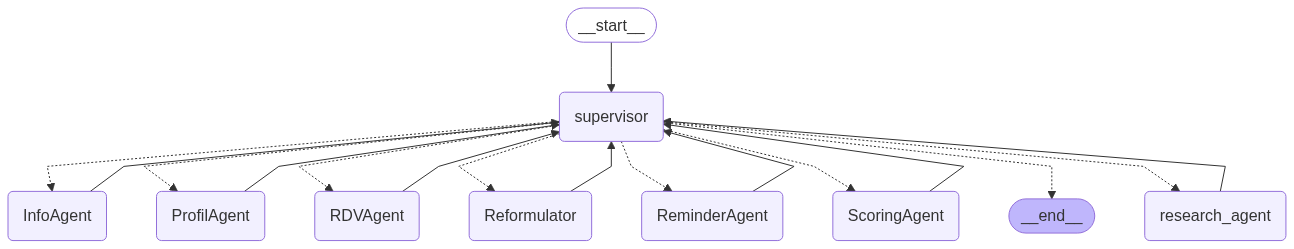

In [23]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))

In [28]:
import pretty
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "Bonjour, je m'appelle Oussama, je cherche un appartement à Rabat pour un budget de 900 000 MAD. Je veux visiter le bien dès que possible.",
            }
        ]
    },
):
    pretty.pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel is_last_step, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.


Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_profilagent

Successfully transferred to ProfilAgent


Update from node ProfilAgent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor




Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel is_last_step, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.


Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_infoagent

Successfully transferred to InfoAgent


Update from node InfoAgent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor




Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel is_last_step, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.


Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_reformulator

Successfully transferred to Reformulator


Update from node Reformulator:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

Bonjour Oussama! C'est un plaisir de vous aider dans votre recherche d'appartement à Rabat. Avec votre budget de 900 000 MAD, nous allons trouver le bien idéal pour vous. Je comprends que vous souhaitez visiter les biens rapidement, et je vais m'en occuper personnellement pour organiser cela au plus vite. Soyez assuré que je suis là pour vous accompagner à chaque étape de votre projet immobilier.




In [20]:
#!pip install lightrag

In [28]:
from langchain_core.messages import convert_to_messages


def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

## Tools

**1. InfoAgent — Accès RAG Immobilier via FastMCP**

In [40]:
# !pip install sseclient-py
!pip show sseclient-py

Name: sseclient-py
Version: 1.8.0
Summary: SSE client for Python
Home-page: https://github.com/mpetazzoni/sseclient
Author: Maxime Petazzoni
Author-email: maxime.petazzoni@bulix.org
License: Apache Software License v2
Location: C:\Users\Oussama\Documents\AIProjects\2-EXP\Snd_v\snd-v\Lib\site-packages
Requires: 
Required-by: 


Bloc 1 – version SSE (streaming)

* `False` ⇒ réponse entière sur POST `/mcp/run`.
* `True` ⇒ uniquement un accusé sur `/run`, puis les données arrivent via `/events`.

In [ ]:
# from langchain.tools import Tool
# import requests, sseclient, json

# def stream_realestate_database(query: str) -> str:
#     """
#     Interroge `search_data` en streaming SSE et renvoie la réponse finale.
#     """
#     # 1) ouverture du flux
#     es = sseclient.SSEClient("http://0.0.0.0:8443/mcp/events")

#     # 2) publication de la requête (stream=True)
#     requests.post("http://0.0.0.0:8443/mcp/run", json={
#         "tool":   "search_data",
#         "args":   {"query": query},
#         "stream": True
#     })

#     # 3) lecture des events
#     answer_chunks = []
#     for event in es.events():
#         data = json.loads(event.data)

#         # • chaque chunk peut contenir un delta à afficher live
#         if data.get("delta"):
#             answer_chunks.append(data["delta"])

#         # • message final → on ferme
#         if data.get("done"):
#             es.close()
#             return "".join(answer_chunks)

# rag_tool = Tool(
#     name="RealEstateRAGTool",
#     func=stream_realestate_database,
#     description="Interroge la base RAG en streaming SSE."
# )


Bloc 2 – version HTTP (recommandée pour l’InfoAgent)

In [49]:
# from langchain.tools import Tool
# import requests, json, logging

# def query_realestate_database(query: str, *, limit: int = 8) -> str:
#     """
#     Interroge le MCP tool `search_data` en mode HTTP (réponse unique).
#     """
#     payload = {
#         "tool":   "search_data",
#         "args":   {"query": query, "limit": limit},
#         "stream": False                         # ➜ JSON complet
#     }
#     r = requests.post(
#         "http://0.0.0.0:8050/mcp/run", json=payload, timeout=60
#     )
#     r.raise_for_status()
#     data = r.json()                            # {"answer": "...", ...}
#     logging.debug("RAG context : %s", json.dumps(data["context"], indent=2))
#     return data["answer"]
#     # Si on veux le contexte complet, on renvoie json.dumps(data).

# rag_tool = Tool(
#     name="RealEstateRAGTool",
#     func=query_realestate_database,
#     description="Interroge la base immobilière RAG (projets, prix, localisation…)."
# )


2. ProfilAgent — Stockage dans un CRM local ou fichier

In [42]:
def store_profile_data(data: str):
    with open("client_profiles.json", "a") as f:
        f.write(data + "\\n")
    return "Profile saved."

profile_storage_tool = Tool(
    name="ProfileSaver",
    func=store_profile_data,
    description="Stores collected client info (JSON) in the CRM."
)


3. RDVAgent — Agenda Google ou local

In [43]:
def check_calendar_and_schedule(message: str):
    # Simuler ici un agenda, ou interagir avec Google Calendar API
    return "Rendez-vous confirmé pour samedi 10h à Rabat."

rdv_calendar_tool = Tool(
    name="AppointmentScheduler",
    func=check_calendar_and_schedule,
    description="Schedule client visits based on calendar availability."
)
